In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1. *damage_labeling.csv* 제작하기
* Raw data 목록으로부터 모델이 데이터셋을 로드할 때 읽을 .csv 및 .json 파일을 생성한다.

In [ ]:
# make index list
damage_json_list = []
for filename in os.listdir("/content/drive/MyDrive/Co-deep/data/Dataset/1.원천데이터/damage"):
  damage_json_list.append(filename)

In [ ]:
N = 2000
total_anns = []
Scratched = []
Breakage = []
Separated = []
Crushed = []
ran_var = [0 for i in range(N)]


PATH = "/content/drive/MyDrive/Co-deep/data/Dataset/2.라벨링데이터/damage"
for filename in os.listdir("/content/drive/MyDrive/Co-deep/data/Dataset/2.라벨링데이터/damage"):
    path = PATH + str('/') + filename
    with open(str(path), "r") as json_file:
      json_load = json.load(json_file)
      # total_anns
      total_anns.append(len(json_load['annotations']))
      # 4개
      dm_list = []
      for i in json_load['annotations']:
        dm_list.append(i['damage'])
      
      Scratched.append(sum(np.array(dm_list) == "Scratched"))
      Breakage.append(sum(np.array(dm_list) == "Breakage"))
      Separated.append(sum(np.array(dm_list) == "Separated"))
      Crushed.append(sum(np.array(dm_list) == "Crushed"))

In [ ]:
# for spliting train / val / test dataset
tvt_split=[]
for i in range(N):
  if i % 7 == 5:
    tvt_split.append('val')
  elif i % 7 == 6:
    tvt_split.append('test')
  else:
    tvt_split.append('train')

In [ ]:
Counter(tvt_split)

Counter({'train': 1430, 'val': 285, 'test': 285})

In [ ]:
damage_labeling = pd.concat([pd.DataFrame(damage_json_list), pd.DataFrame(Scratched), pd.DataFrame(Breakage), pd.DataFrame(Separated), 
                             pd.DataFrame(Crushed), pd.DataFrame(total_anns), pd.DataFrame(ran_var), pd.DataFrame(tvt_split)], axis = 1)
damage_labeling.columns = ['index', 'Scratched', 'Breakage', 'Separated', 'Crushed', 'total_anns', 'ran_var', 'dataset']
damage_labeling

,index,Scratched,Breakage,Separated,Crushed,total_anns,ran_var,dataset
0,0507432_as-3314287.jpg,2,2,1,1,6,0,train
1,0507420_sc-1040741.jpg,3,0,0,0,3,0,train
2,0507445_as-0046949.jpg,2,0,1,0,3,0,train
3,0507468_as-7373159.jpg,4,0,0,0,4,0,train
4,0507469_sc-116500.jpg,4,2,3,0,9,0,train
...,...,...,...,...,...,...,...,...
1995,0507478_as-3147515.jpg,1,1,1,1,4,0,train
1996,0507416_sc-104825.jpg,0,0,1,0,1,0,train
1997,0507477_sc-196898.jpg,1,0,0,1,2,0,train
1998,0507426_sc-181541.jpg,1,0,1,0,2,0,train


In [ ]:
# damage_labeling.to_csv('/content/drive/MyDrive/Co-deep/code/damage_labeling.csv')

### 2. Revise annotation files to *Coco format*

기존 Annotation 파일 형식을 데이터를 load할 수 있는 형태로 바꾸어주는 단계이다.

In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Co-deep/')

!python code/src/Utils.py --make_cocoformat 1 --task damage

# annotation format 
# {
# 'info': {'name': 'external', 'date_created': '03/08/2022'},
# 'images': [{'id': 1, 'width': 800, 'height':600, 'file_name': '*.jpg'}, {'id': 2, ... }, ... ]
# 'annotations': [{'id': 1, 'image_id': 1, 'category_id': _, 'segmentation': [[xxx.xxx, ... ]] , ...  }, {'id': 1, ...}, ... ] # 여기의 id는 ann id
# }

### 3. Visualizing Original Image and Annotation

학습시키기 이전, 모델에 입력되는 원본 사진들과 annotation이 잘 맞는지 확인하는 작업을 거쳤다.

3-1. Load original image

In [ ]:
import os
import cv2
from pycocotools.coco import COCO
from google.colab.patches import cv2_imshow

os.chdir('/content/drive/MyDrive/Co-deep/code')
img_base_path = '/content/drive/MyDrive/Co-deep/data/Dataset/1.원천데이터/damage'
train_dir = f"../data/datainfo/damage_Scratched_train.json"
coco = COCO(train_dir)

index = 45
image_id = coco.getImgIds([index])
image_infos = coco.loadImgs(image_id)[0]


image = cv2.imread(os.path.join(img_base_path, image_infos['file_name']))
cv2_imshow(image)

3-2. Plot annotation polygon on original image

In [ ]:
import numpy as np

ann_ids = coco.getAnnIds(imgIds=image_infos['id']) # image id로 부터 대응되는 annotation id 가져오기
anns = coco.loadAnns(ann_ids)  # ann id는 고유값을 가지도록 첫번째 이미지의 annotation부터 누적

print(ann_ids)
print(anns)

img_with_ann = image.copy()

# ann['sementation'] 읽어와 원본 이미지에 plot
for ann in anns:
  if ann['damage'] == 'Separated':
  # if ann['damage'] == 'Scratched':
    print(ann['id'], ann['segmentation'])
    poly_list = []
    for point_float in ann["segmentation"][0]:
      point_list = []
      x, y = str(point_float).split('.')
      point_list.append(int(x))
      point_list.append(int(y))
      poly_list.append(point_list)
    poly = np.array(poly_list)
    img_with_ann = cv2.polylines(img_with_ann, [poly], True, (0,255,0), thickness=2)


cv2_imshow(img_with_ann)

[2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614]
[{'id': 2607, 'image_id': 866, 'category_id': 0, 'segmentation': [[284.186, 309.186, 306.206, 281.246, 285.274, 277.287, 264.287, 245.262, 278.216, 284.186]], 'area': 2645.5, 'bbox': [245, 186, 64, 101], 'damage': 'Scratched', 'part': None, 'year': 2016, 'color': 'White', 'level': None, 'repair': ['Front bumper:repair,coating,sheet_metal']}, {'id': 2608, 'image_id': 866, 'category_id': 0, 'segmentation': [[202.337, 211.351, 209.365, 182.361, 202.337]], 'area': 441.0, 'bbox': [182, 337, 29, 28], 'damage': 'Scratched', 'part': None, 'year': 2016, 'color': 'White', 'level': None, 'repair': ['Front bumper:repair,coating,sheet_metal']}, {'id': 2609, 'image_id': 866, 'category_id': 0, 'segmentation': [[21.42, 29.48, 36.64, 16.58, 4.85, 0.59, 21.42]], 'area': 553.5, 'bbox': [0, 42, 36, 43], 'damage': 'Scratched', 'part': None, 'year': 2016, 'color': 'White', 'level': None, 'repair': ['Front bumper:repair,coating,sheet_metal']}, {'id': 2610, 'im

### 4. Train & Validation

##### 5-1. BCE Loss 실험
- `criterion = torch.nn.BCELossWithLogits()`

In [ ]:
### 실험 2-1
# damage
# BCELoss
# new model
# th - 0.4

!python main.py --train y --task damage --label all

In [ ]:
### 실험 2-2
# damage
# BCELoss
# new model
# th - 0.6

!python main.py --train y --task damage --label all

In [ ]:
### 실험 2-3
# damage
# BCELoss
# new model
# th - 0.3

!python main.py --train y --task damage --label all

In [ ]:
### 실험 2-4
# damage
# BCELoss
# new model
# th - 0.25

!python main.py --train y --task damage --label all

##### 5-2. Focal Loss 실험 (threshold = 0.475)

In [ ]:
### 실험 1-1
# damage
# FocalLoss
# new model
# th - 0.35

!python main.py --train y --task damage --label all  

# 전부 target으로 예측해버림 

In [ ]:
### 실험 1-2
# damage
# FocalLoss
# new model
# th - 0.75

!python main.py --train y --task damage --label all

In [ ]:
### 실험 1-3
# damage
# FocalLoss
# new model
# th - 0.5

!python main.py --train y --task damage --label all

In [1]:
### 실험 1-4
# damage
# FocalLoss
# new model
# th - 0.4
# 보면 0.35는 target으로만 하고 0.5, 0.75는 background로만 하니까..!

!python main.py --train y --task damage --label all

python3: can't open file 'main.py': [Errno 2] No such file or directory


In [ ]:
### 실험 1-5
# damage
# FocalLoss
# new model
# th - 0.45
# 보면 0.35, 0.4는 target으로만 하고 0.5, 0.75는 background로만 하니까..!

!python main.py --train y --task damage --label all

In [ ]:
### 실험 1-6
# damage
# FocalLoss
# new model
# th - 0.475
# 보면 0.35, 0.4, 0.45는 target으로만 하고 0.5, 0.75는 background로만 하니까..!

!python main.py --train y --task damage --label all

In [ ]:
### 실험 1-7
# damage
# FocalLoss
# new model
# th - 0.48
# 보면 0.35, 0.4, 0.45는 target으로만 하고 0.5, 0.75는 background로만 하니까..!

!python main.py --train y --task damage --label all

In [ ]:
### 실험 3-1 ######################################################### 별
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
# th - 0.475
# FocalLoss alpha = 0.25, gamma=2

!python main.py --train y --task damage --label all  
# 문제점 : 개선이 되지 않고 수치가 아예 동일하다.
# 사실상 이게 가능한 문제인지 모르겠다. 

In [ ]:
### 실험 3-2
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
# th - 0.5
# FocalLoss alpha = 0.25, gamma=2

!python main.py --train y --task damage --label all  
# 문제점 : 개선이 되지 않고 수치가 아예 동일하다.
# 사실상 이게 가능한 문제인지 모르겠다. 

In [ ]:
# alpha = 0.2, 0.25, 0.75
# gamma = 1,2,3

In [ ]:
### 실험 3-3
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
# th - 0.475
# FocalLoss alpha = 0.2, gamma=1

!python main.py --train y --task damage --label all 

In [ ]:
### 실험 3-4
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
#### th - 0.475 : 고정 : 그냥 이게 최고인 것이야ㅑ
# FocalLoss alpha = 0.2, gamma=2

!python main.py --train y --task damage --label all 

In [ ]:
### 실험 3-4
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
#### th - 0.475 : 고정 : 그냥 이게 최고인 것이야ㅑ
# FocalLoss alpha = 0.2, gamma=3

!python main.py --train y --task damage --label all

In [ ]:
### 실험 3-5
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
#### th - 0.475 : 고정 : 그냥 이게 최고인 것이야ㅑ
# FocalLoss alpha = 0.25, gamma=1

!python main.py --train y --task damage --label all

In [ ]:
### 실험 3-5
# damage
# FocalLoss : 새로운 걸로 바꿨다. 
# new model
#### th - 0.475 : 고정 : 그냥 이게 최고인 것이야ㅑ
# FocalLoss alpha = 0.25, gamma=2

!python main.py --train y --task damage --label all

#### 5-3. Train (w. Dice Loss)

5-1, 5-2는 trial and error로, 최종 학습은 Dice Loss로 학습하였다.

In [ ]:
!pip install segmentation-models-pytorch

최종 결과

In [ ]:
import os
os.chdir("/content/drive/MyDrive/Co-deep/code")
!python main.py --train y --task damage --label all  

gpu device num
0
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
name: socar
date_created: 03/08/2022
None
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
name: socar
date_created: 03/08/2022
None
--- start-training ---
Loaded train data: 1264
Loaded val data: 285
epoch: 1
step 0 | loss 0.8518046140670776
step 10 | loss 0.8135462999343872
step 20 | loss 0.8304505944252014
step 30 | loss 0.761221706867218
step 40 | loss 0.7964877486228943
step 50 | loss 0.7655830383300781
step 60 | loss 0.774547815322876
step 70 | loss 0.6867213249206543
number of classes: 1
Start validation # epoch 1 # step 78
[[12147958.  4929602.]
 [  485060.  1115140.]]
Validation #1 #17 Average Loss: 0.7475, mIoU: 0.4312, background IoU : 0.6917, target IoU : 0.1708, precision : 0.1845, recall : 0.6969, F1_score : 0.2917, balanced_accuracy : 1.0513
avrg_loss, mIoU, cls_IoU : tensor(0.7475, device='cuda:0') 0.43123547529025397 [0.69169395 0.170777

### cf. Defining Customized function
pycocotools 의 `annToMask()`가 현재 우리의 데이터셋 형식으로는 적용이 잘 안 되어서 유사한 함수를 정의하였다.

(Utils.py의 `customizedAnnToMask()`)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

def customizedAnnToMask(ann, height, width):  # 'segmentation': [[ [x.y], [x.y], ...  , [x.y] ]]

  coco_seg = ann['segmentation'][0]
  contours = []

  # [x.y] -> [x,y]

  for point in coco_seg:
    point = str(point)
    x, y = point.split('.')
    revised_point = [int(x), int(y)]
    contours.append(revised_point)
  
  ann_mask = np.zeros((height, width))
  contours = np.asarray(contours, dtype=np.int32)
  cv2.fillPoly( ann_mask, pts=[contours], color=(1, 1, 1))
  
  return ann_mask  

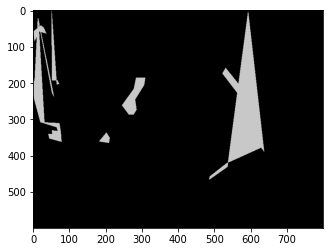

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mask = np.zeros((image_infos['height'], image_infos['width']))

for ann in anns:
  if ann['category_id'] == 0:
    mask = np.maximum(customizedAnnToMask(ann, image_infos['height'], image_infos['width'], ann['category_id']), mask)
    masks = masks.astype(np.int32)
  
mask = mask * 100 # pixel 값이 1이면 육안으로 0과 1 구분이 안돼서
plt.imshow(mask, cmap='gray', vmin=0, vmax=255)


### cf. Trial for loading pretrained model and fine tuning

weight의 shape이 맞지 않아 pretrained model을 load하는데 실패하였다.

In [ ]:
["../data/weight/"+n for n in ["[DAMAGE][Scratch_0]Unet.pt","[DAMAGE][Seperated_1]Unet.pt","[DAMAGE][Crushed_2]Unet.pt","[DAMAGE][Breakage_3]Unet.pt"]]

['../data/weight/[DAMAGE][Scratch_0]Unet.pt',
 '../data/weight/[DAMAGE][Seperated_1]Unet.pt',
 '../data/weight/[DAMAGE][Crushed_2]Unet.pt',
 '../data/weight/[DAMAGE][Breakage_3]Unet.pt']

In [ ]:
!python main.py --eval y --task damage --label all

gpu device num
0
start_validation damage Scratched
conv1.weight
###########
bn1.running_mean
###########
bn1.running_var
###########
bn1.weight
###########
bn1.bias
###########
layer1.0.conv1.weight
###########
layer1.0.bn1.running_mean
###########
layer1.0.bn1.running_var
###########
layer1.0.bn1.weight
###########
layer1.0.bn1.bias
###########
layer1.0.conv2.weight
###########
layer1.0.bn2.running_mean
###########
layer1.0.bn2.running_var
###########
layer1.0.bn2.weight
###########
layer1.0.bn2.bias
###########
layer1.1.conv1.weight
###########
layer1.1.bn1.running_mean
###########
layer1.1.bn1.running_var
###########
layer1.1.bn1.weight
###########
layer1.1.bn1.bias
###########
layer1.1.conv2.weight
###########
layer1.1.bn2.running_mean
###########
layer1.1.bn2.running_var
###########
layer1.1.bn2.weight
###########
layer1.1.bn2.bias
###########
layer1.2.conv1.weight
###########
layer1.2.bn1.running_mean
###########
layer1.2.bn1.running_var
###########
layer1.2.bn1.weight
##########

In [ ]:
!python main.py --eval y --task damage --label all

gpu device num
0
start_validation damage Scratched
conv1.weight
###########
model.encoder.conv1.weight
bn1.running_mean
###########
model.encoder.bn1.running_mean
bn1.running_var
###########
model.encoder.bn1.running_var
bn1.weight
###########
model.encoder.bn1.weight
bn1.bias
###########
model.encoder.bn1.bias
layer1.0.conv1.weight
###########
model.encoder.layer1.0.conv1.weight
layer1.0.bn1.running_mean
###########
model.encoder.layer1.0.bn1.running_mean
layer1.0.bn1.running_var
###########
model.encoder.layer1.0.bn1.running_var
layer1.0.bn1.weight
###########
model.encoder.layer1.0.bn1.weight
layer1.0.bn1.bias
###########
model.encoder.layer1.0.bn1.bias
layer1.0.conv2.weight
###########
model.encoder.layer1.0.conv2.weight
layer1.0.bn2.running_mean
###########
model.encoder.layer1.0.bn2.running_mean
layer1.0.bn2.running_var
###########
model.encoder.layer1.0.bn2.running_var
layer1.0.bn2.weight
###########
model.encoder.layer1.0.bn2.weight
layer1.0.bn2.bias
###########
model.encoder.l

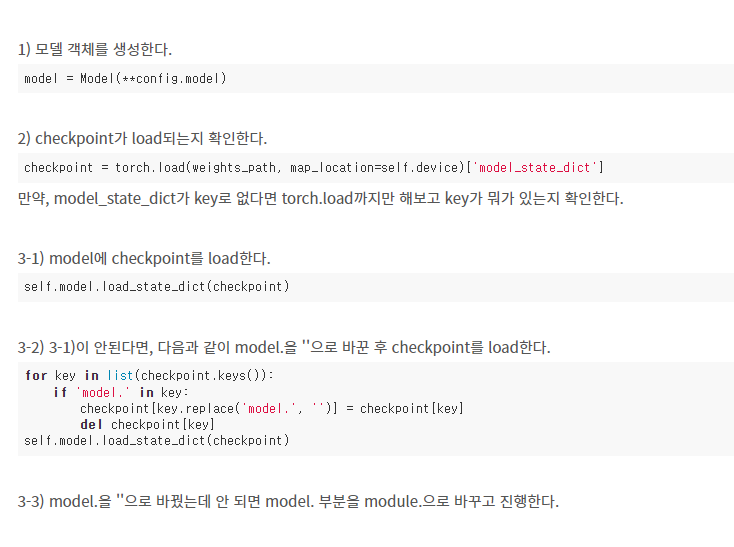